In [2]:
import pandas as pd
import numpy as np

In [8]:
# import os
os.listdir("./data/dataset")

['other_importance_fea.parquet',
 'valid_raw.parquet',
 'train.parquet',
 'valid_importance_fea.parquet',
 'train_importance_fea.parquet',
 'train_labels.csv']

In [7]:
# train_df = pd.read_parquet('./data/dataset/train.parquet')
valid_df = pd.read_parquet('./data/datatset/valid_raw.parquet')
# targets = pd.read_csv('./data/dataset/train_labels.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/datatset/valid_raw.parquet'

In [9]:
def process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]
    valid_cat_features = [fea for fea in cat_features if fea in all_cols]

    test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    test_cat_agg = pd.DataFrame()
    if len(valid_cat_features) != 0:
        test_cat_agg = df.groupby("customer_ID")[valid_cat_features].agg(['count', 'last', 'nunique'])
        test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    df = pd.concat([test_num_agg, test_cat_agg], axis=1)
    del test_num_agg, test_cat_agg
    print('shape after engineering', df.shape )

    return df
    

In [ ]:
train_fea = process_and_feature_engineer(train_df).reset_index()
# valid_fea = process_and_feature_engineer(valid_df).reset_index()

In [27]:
train_fea_label = pd.merge(train_fea, targets, left_on="customer_ID", right_on="customer_ID", how="left")
valid_fea_label = pd.merge(valid_fea, targets, left_on="customer_ID", right_on="customer_ID", how="left")

In [29]:
train_X = train_fea_label[train_fea_label.columns[1:-1]]
train_y = train_fea_label[train_fea_label.columns[-1]]

valid_X = valid_fea_label[valid_fea_label.columns[1:-1]]
valid_y = valid_fea_label[valid_fea_label.columns[-1]]

In [18]:
import xgboost as xgb
SEED = 123

In [31]:
train_dmatrix = xgb.DMatrix(data=train_X, label=train_y)
valid_dmatrix = xgb.DMatrix(data=valid_X, label=valid_y)

In [19]:
xgb_parms = { 
    'max_depth':4, 
    'learning_rate':0.05, 
    'subsample':0.8,
    'colsample_bytree':0.6, 
    'eval_metric':'logloss',
    'objective':'binary:logistic',
    'random_state':SEED
}

In [32]:
model = xgb.train(xgb_parms, 
            dtrain=train_dmatrix,
            evals=[(train_dmatrix,'train'),(valid_dmatrix,'valid')],
            num_boost_round=9999,
            early_stopping_rounds=100,
            verbose_eval=100) 

[0]	train-logloss:0.66277	valid-logloss:0.66035
[100]	train-logloss:0.24618	valid-logloss:0.21620
[200]	train-logloss:0.23111	valid-logloss:0.20490
[300]	train-logloss:0.22479	valid-logloss:0.20172
[400]	train-logloss:0.22054	valid-logloss:0.20016
[500]	train-logloss:0.21714	valid-logloss:0.19941
[600]	train-logloss:0.21430	valid-logloss:0.19889
[700]	train-logloss:0.21162	valid-logloss:0.19853
[800]	train-logloss:0.20918	valid-logloss:0.19819
[900]	train-logloss:0.20703	valid-logloss:0.19807
[1000]	train-logloss:0.20495	valid-logloss:0.19779
[1100]	train-logloss:0.20282	valid-logloss:0.19751
[1200]	train-logloss:0.20085	valid-logloss:0.19740
[1300]	train-logloss:0.19886	valid-logloss:0.19726
[1400]	train-logloss:0.19701	valid-logloss:0.19730
[1404]	train-logloss:0.19694	valid-logloss:0.19727


In [33]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [39]:
oof_preds = model.predict(valid_dmatrix)
acc = amex_metric_mod(valid_y.values, oof_preds)

In [46]:
valid_fea_label['oof_pred'] = oof_preds

In [47]:
valid_fea_label[['customer_ID','target','oof_pred']]


,customer_ID,target,oof_pred
0,ab411046bf88681c563a143a9f80bcbe49fbb862b35bb5...,0,0.071738
1,ab4120e3ce90b543b4ed8604afb5000ede7a791a40f470...,1,0.825575
2,ab41218ee2ff6eb0f1e04090b9cca1d79f661d35a7664e...,0,0.004924
3,ab4163fa084343482ce5068f4b6c54025506d0681e67de...,1,0.792298
4,ab417c9db4a92f0044ad92d8f7cfd8bf1abd323bf80927...,0,0.040354
...,...,...,...
11576,b2eb198ea9e6ef46d179129b859be4b15ed585b3aa5217...,1,0.671760
11577,b2eb1f22792d416e0e2d5259a0f9de71ef7d8d5a2f6266...,0,0.349649
11578,b2eb22124cbe18a9b49c38816be7f83e266276d283e4da...,0,0.000238
11579,b2eb3c26a7c1693a55df8989a6f8e9edbdf0b0c981e41f...,0,0.001855


In [58]:
# Feature importance

fea_score = model.get_score(importance_type='weight')
fea_importance = pd.DataFrame({'feature':fea_score.keys(),'importance':fea_score.values()}).sort_values('importance', ascending=False)

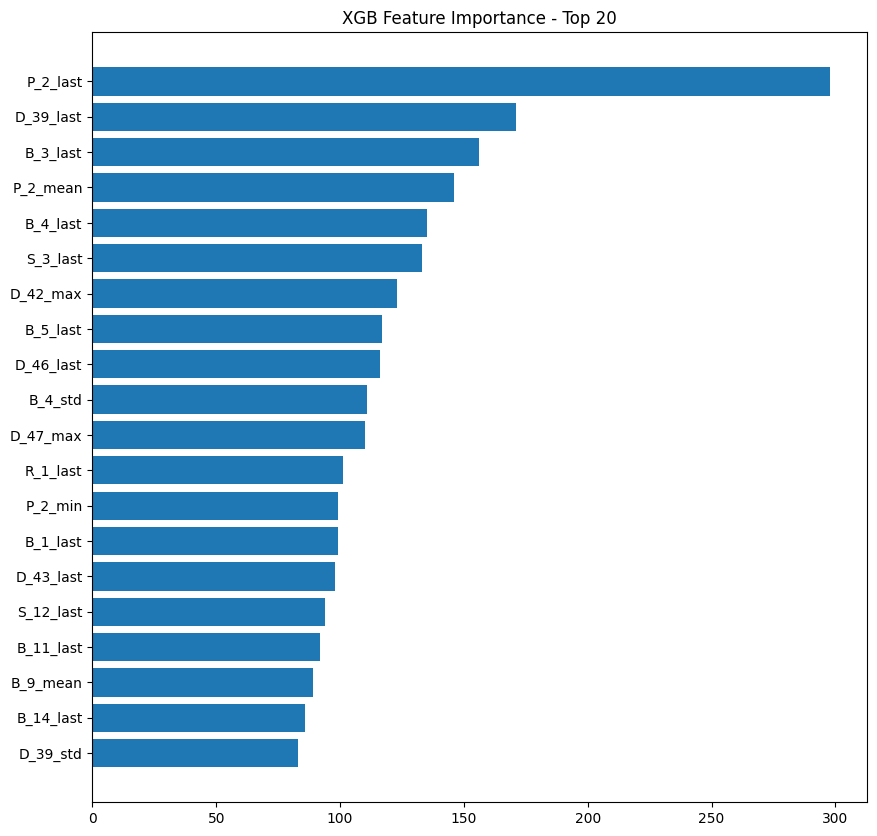

In [61]:
import matplotlib.pyplot as plt

NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), fea_importance.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), fea_importance.feature.values[:NUM_FEATURES])
plt.title(f'XGB Feature Importance - Top {NUM_FEATURES}')
plt.show()

In [72]:
# importance_fea = ['P_2','D_39','B_3','B_4','S_3','D_42','B_5','D_46','D_47','R_1','B_1','D_43','S_12','B_11','B_9','B_14']
importance_fea = ['P_2','D_39','D_42','D_43','D_46','D_47','B_1','B_3','B_4','B_5','B_9','B_11','B_14','S_3','S_12','R_1']

In [75]:
train_df_new = train_df[['customer_ID'] + importance_fea]
valid_df_new = valid_df[['customer_ID'] + importance_fea]

In [82]:
train_fea_new = process_and_feature_engineer(train_df_new).reset_index()
valid_fea_new = process_and_feature_engineer(valid_df_new).reset_index()

shape after engineering (331521, 80)
shape after engineering (11581, 80)


In [89]:
train_fea_label_new = pd.merge(train_fea_new, targets, left_on="customer_ID", right_on="customer_ID", how="left")
valid_fea_label_new = pd.merge(valid_fea_new, targets, left_on="customer_ID", right_on="customer_ID", how="left")

In [90]:
train_X_new = train_fea_label_new[train_fea_label_new.columns[1:-1]]
train_y_new = train_fea_label_new[train_fea_label_new.columns[-1]]

valid_X_new = valid_fea_label_new[valid_fea_label_new.columns[1:-1]]
valid_y_new = valid_fea_label_new[valid_fea_label_new.columns[-1]]

In [91]:
train_dmatrix_new = xgb.DMatrix(data=train_X_new, label=train_y_new)
valid_dmatrix_new = xgb.DMatrix(data=valid_X_new, label=valid_y_new)

In [92]:
model_new = xgb.train(xgb_parms, 
            dtrain=train_dmatrix_new,
            evals=[(train_dmatrix_new,'train'),(valid_dmatrix_new,'valid')],
            num_boost_round=9999,
            early_stopping_rounds=100,
            verbose_eval=100) 

[0]	train-logloss:0.66385	valid-logloss:0.66127
[100]	train-logloss:0.25178	valid-logloss:0.22127
[200]	train-logloss:0.24083	valid-logloss:0.21303
[300]	train-logloss:0.23680	valid-logloss:0.21116
[400]	train-logloss:0.23423	valid-logloss:0.21010
[500]	train-logloss:0.23210	valid-logloss:0.20941
[600]	train-logloss:0.23025	valid-logloss:0.20910
[700]	train-logloss:0.22844	valid-logloss:0.20886
[800]	train-logloss:0.22680	valid-logloss:0.20875
[900]	train-logloss:0.22535	valid-logloss:0.20869
[1000]	train-logloss:0.22382	valid-logloss:0.20858
[1100]	train-logloss:0.22231	valid-logloss:0.20852
[1200]	train-logloss:0.22082	valid-logloss:0.20830
[1300]	train-logloss:0.21943	valid-logloss:0.20829
[1366]	train-logloss:0.21846	valid-logloss:0.20834


In [94]:
oof_preds_new = model_new.predict(valid_dmatrix_new)
acc_new = amex_metric_mod(valid_y_new.values, oof_preds_new)

acc_new

0.7948165149392248

In [95]:
valid_fea_label_new['oof_pred'] = oof_preds_new

valid_fea_label_new[['customer_ID','target','oof_pred']]

,customer_ID,target,oof_pred
0,ab411046bf88681c563a143a9f80bcbe49fbb862b35bb5...,0,0.102235
1,ab4120e3ce90b543b4ed8604afb5000ede7a791a40f470...,1,0.812758
2,ab41218ee2ff6eb0f1e04090b9cca1d79f661d35a7664e...,0,0.002308
3,ab4163fa084343482ce5068f4b6c54025506d0681e67de...,1,0.674303
4,ab417c9db4a92f0044ad92d8f7cfd8bf1abd323bf80927...,0,0.025630
...,...,...,...
11576,b2eb198ea9e6ef46d179129b859be4b15ed585b3aa5217...,1,0.567753
11577,b2eb1f22792d416e0e2d5259a0f9de71ef7d8d5a2f6266...,0,0.690741
11578,b2eb22124cbe18a9b49c38816be7f83e266276d283e4da...,0,0.000473
11579,b2eb3c26a7c1693a55df8989a6f8e9edbdf0b0c981e41f...,0,0.003023
